Loaded bank-full.csv from local path.
Shape: (45211, 17)
   age           job  marital  education default  balance housing loan  \
0   58    management  married   tertiary      no     2143     yes   no   
1   44    technician   single  secondary      no       29     yes   no   
2   33  entrepreneur  married  secondary      no        2     yes  yes   
3   47   blue-collar  married    unknown      no     1506     yes   no   
4   33       unknown   single    unknown      no        1      no   no   

   contact  day month  duration  campaign  pdays  previous poutcome   y  
0  unknown    5   may       261         1     -1         0  unknown  no  
1  unknown    5   may       151         1     -1         0  unknown  no  
2  unknown    5   may        76         1     -1         0  unknown  no  
3  unknown    5   may        92         1     -1         0  unknown  no  
4  unknown    5   may       198         1     -1         0  unknown  no  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521

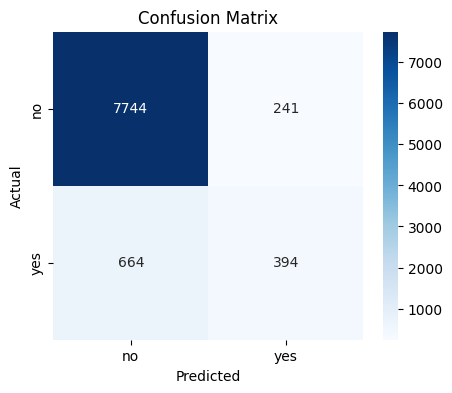

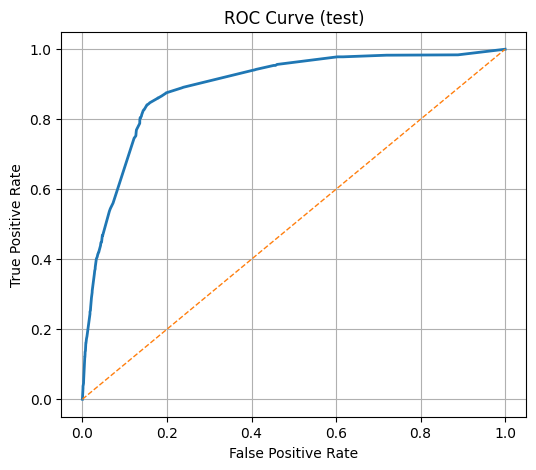

Num features after preprocessing: 51
Top features:
 duration               0.465072
poutcome_success       0.208870
contact_unknown        0.079635
housing_no             0.039795
pdays                  0.026103
month_jul              0.021779
month_aug              0.017573
month_mar              0.014821
month_nov              0.014479
day                    0.012851
month_oct              0.012137
age                    0.011464
month_jun              0.009770
balance                0.009724
month_may              0.008665
poutcome_unknown       0.008214
campaign               0.007975
housing_yes            0.005351
previous               0.004809
contact_cellular       0.004583
month_apr              0.003267
loan_no                0.002821
month_feb              0.001541
education_secondary    0.001401
education_tertiary     0.001136
marital_married        0.001132
month_sep              0.000886
marital_single         0.000821
job_technician         0.000722
job_management      

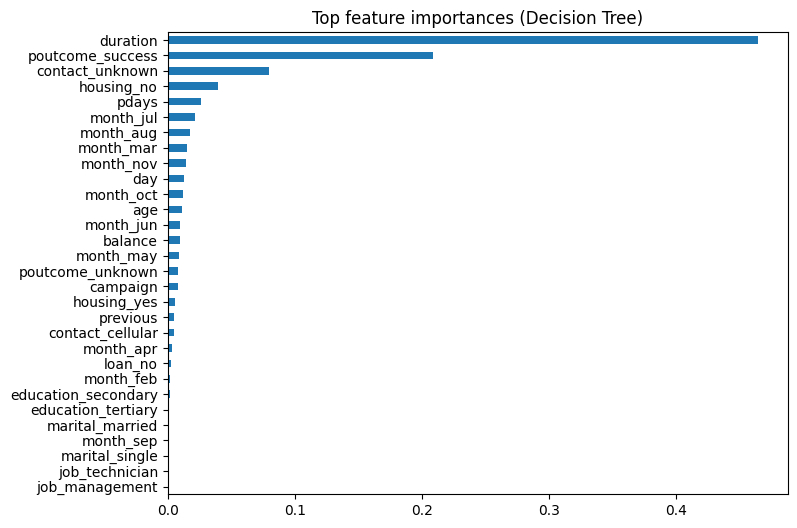

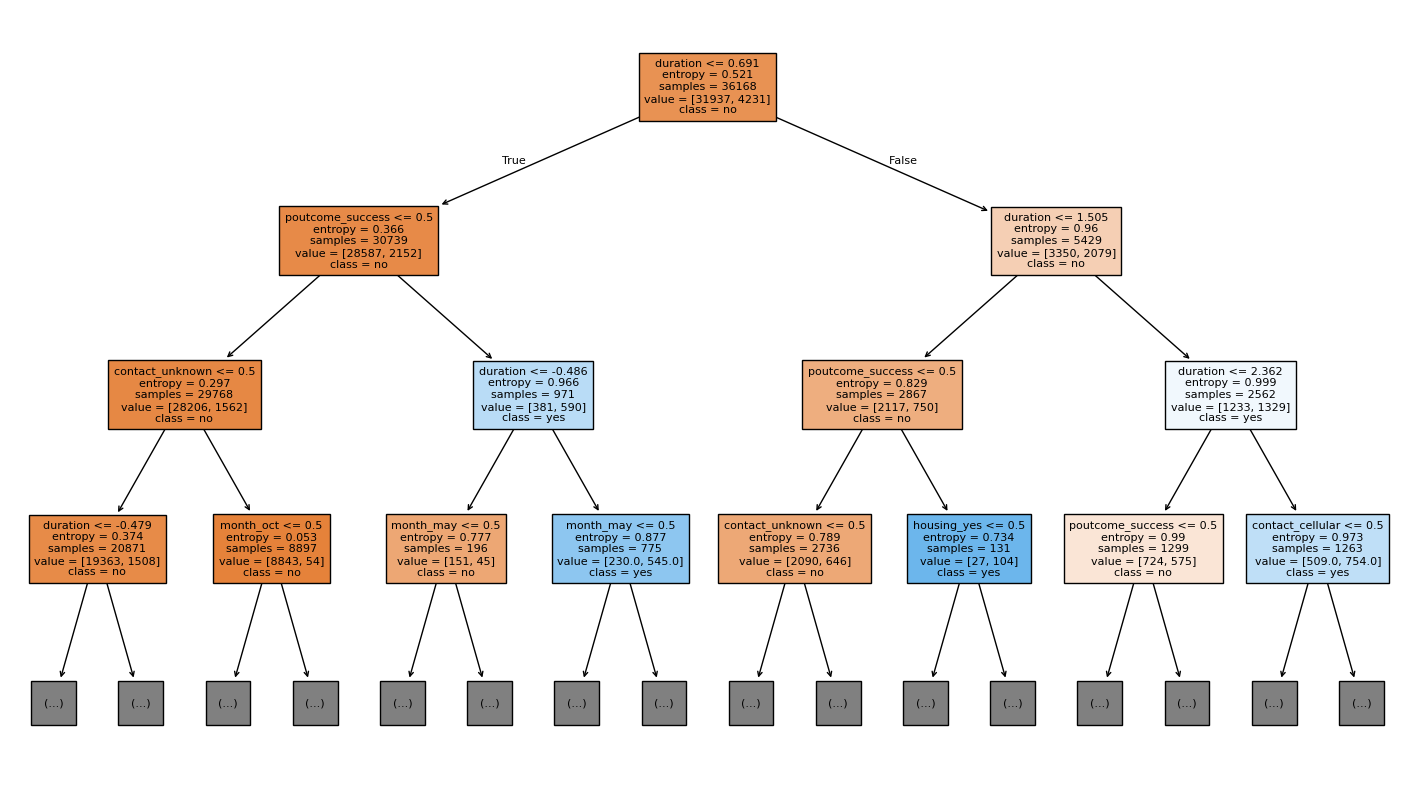

|--- duration <= 0.69
|   |--- poutcome_success <= 0.50
|   |   |--- contact_unknown <= 0.50
|   |   |   |--- duration <= -0.48
|   |   |   |   |--- duration <= -0.70
|   |   |   |   |   |--- duration <= -0.76
|   |   |   |   |   |   |--- age <= 2.55
|   |   |   |   |   |   |   |--- day <= -1.60
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- day >  -1.60
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- age >  2.55
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- duration >  -0.76
|   |   |   |   |   |   |--- month_feb <= 0.50
|   |   |   |   |   |   |   |--- education_tertiary <= 0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- education_tertiary >  0.50
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |--- month_feb >  0.50
|   |   |   |   |   |   |   |--- day <= -0.52
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- day >  -

In [5]:
# Decision tree classifier for Bank Marketing (scikit-learn)
# Save as bank_marketing_decision_tree.py or run in notebook cells.

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_auc_score,
    roc_curve,
    accuracy_score,
)
import matplotlib.pyplot as plt
import seaborn as sns  # only for nicer plotting (optional)

# 1) Load the dataset
# Option A: from a local CSV path
# df = pd.read_csv("bank-full.csv", sep=';')

# Option B: if you want to load from the GitHub sample repo (raw CSV) use:
# df = pd.read_csv("https://raw.githubusercontent.com/Prodigy-InfoTech/data-science-datasets/main/Task%203/bank-full.csv", sep=';')

# For flexibility, try reading a local path first, otherwise attempt GitHub raw.
try:
    df = pd.read_csv("bank-full.csv", sep=';')
    print("Loaded bank-full.csv from local path.")
except Exception:
    url = "https://raw.githubusercontent.com/Prodigy-InfoTech/data-science-datasets/main/Task%203/bank-full.csv"
    df = pd.read_csv(url, sep=';')
    print("Loaded bank-full.csv from GitHub raw URL.")

print("Shape:", df.shape)
print(df.head())

# 2) Quick data checks
print(df.info())
print(df.isnull().sum())  # dataset usually has no missing values
print(df['y'].value_counts())

# 3) Prepare input X and target y
X = df.drop(columns=['y'])
y_raw = df['y'].copy()  # 'yes' / 'no'
le = LabelEncoder()
y = le.fit_transform(y_raw)  # yes -> 1, no -> 0
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

# 4) Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns.tolist()
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print("Categorical columns:", categorical_cols)
print("Numerical columns:", numerical_cols)

# 5) Build preprocessing pipelines
cat_transformer = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
num_transformer = Pipeline([
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop'
)

# 6) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print("Train/test sizes:", X_train.shape, X_test.shape)

# 7) Create a pipeline with a DecisionTreeClassifier
clf = Pipeline([
    ('preproc', preprocessor),
    ('dt', DecisionTreeClassifier(random_state=42))
])

# 8) Hyperparameter search (GridSearchCV)
param_grid = {
    'dt__max_depth': [3, 5, 8, 12, None],
    'dt__min_samples_split': [2, 5, 10, 20],
    'dt__min_samples_leaf': [1, 2, 5, 10],
    'dt__criterion': ['gini', 'entropy'],
    # 'dt__class_weight': [None, 'balanced']  # optional
}

grid = GridSearchCV(
    clf, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1
)
grid.fit(X_train, y_train)

print("Best params:", grid.best_params_)
print("Best CV ROC AUC:", grid.best_score_)

best_model = grid.best_estimator_

# 9) Evaluation on test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

print("Test accuracy:", accuracy_score(y_test, y_pred))
print("Test ROC AUC:", roc_auc_score(y_test, y_proba))
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1],[0,1],'--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (test)')
plt.grid(True)
plt.show()

# 10) Feature importance & tree visualization
# We need feature names after OneHotEncoder
ohe = best_model.named_steps['preproc'].named_transformers_['cat'].named_steps['onehot']
if hasattr(ohe, 'get_feature_names_out'):
    cat_feature_names = ohe.get_feature_names_out(categorical_cols)
else:
    cat_feature_names = ohe.get_feature_names(categorical_cols)

feature_names = numerical_cols + list(cat_feature_names)
print("Num features after preprocessing:", len(feature_names))

# Feature importances
dt = best_model.named_steps['dt']
importances = dt.feature_importances_
feat_imp = pd.Series(importances, index=feature_names).sort_values(ascending=False).head(30)
print("Top features:\n", feat_imp)

plt.figure(figsize=(8,6))
feat_imp.plot(kind='barh')
plt.gca().invert_yaxis()
plt.title('Top feature importances (Decision Tree)')
plt.show()

# Visualize the tree (plot small tree)
plt.figure(figsize=(18,10))
# limit depth for readability
plot_tree(dt, feature_names=feature_names, class_names=le.classes_, filled=True, max_depth=3, fontsize=8)
plt.show()

# Export textual tree (optional)
text_tree = export_text(dt, feature_names=list(feature_names))
print(text_tree[:1000])  # print first 1000 chars